In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Example – DeepONets

# Resources
* Paper - https://www.nature.com/articles/s42256-021-00302-5
* GitHub - https://github.com/lululxvi/deeponet?tab=readme-ov-file
* DeepXDE - https://deepxde.readthedocs.io/en/latest/demos/operator.html

# Learning 1D Antiderivative Operator

$$
\frac{dv}{dx} = u(x) \quad x \in [0,1].\\
v(0) = 0.
$$

* Discretize $\Omega = [0,1]$ into $m = 100$ degrees of freedom at which we evaluate $u(x)$.
* DeepONet
$$
G_{\theta}:R^{N \times m} \times R^{q \times 1} \to R^{N \times q}.
$$

In [2]:
import numpy as np
import tqdm

# Jax
import jax
import jax.numpy as jnp
import jax.random as jr
# Enable Float64 for more stable matrix inversions.
from jax import config
config.update("jax_enable_x64", True)

# Neural Network
try:
  import optax
except:
  !pip install optax --quiet
  import optax
try:
  import equinox as eqx
except:
  !pip install equinox --quiet
  import equinox as eqx

# Typing Imports
key = jr.PRNGKey(42)

# Dataset

In [3]:
# !curl -O https://github.com/mroberto166/CAMLab-DLSCTutorials/blob/main/antiderivative_aligned_train.npz
# !curl -O https://github.com/mroberto166/CAMLab-DLSCTutorials/blob/main/antiderivative_aligned_test.npz

In [4]:
# Training Data
dataset_train = jnp.load("antiderivative_aligned_train.npz", allow_pickle=True)
branch_inputs_train = dataset_train["X"][0]
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"]
branch_inputs_train.shape, trunk_inputs_train.shape, outputs_train.shape

((150, 100), (100, 1), (150, 100))

In [5]:
# Test Data
dataset_test = jnp.load("antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = dataset_test["X"][0]
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"]
branch_inputs_test.shape, trunk_inputs_test.shape, outputs_test.shape

((1000, 100), (100, 1), (1000, 100))

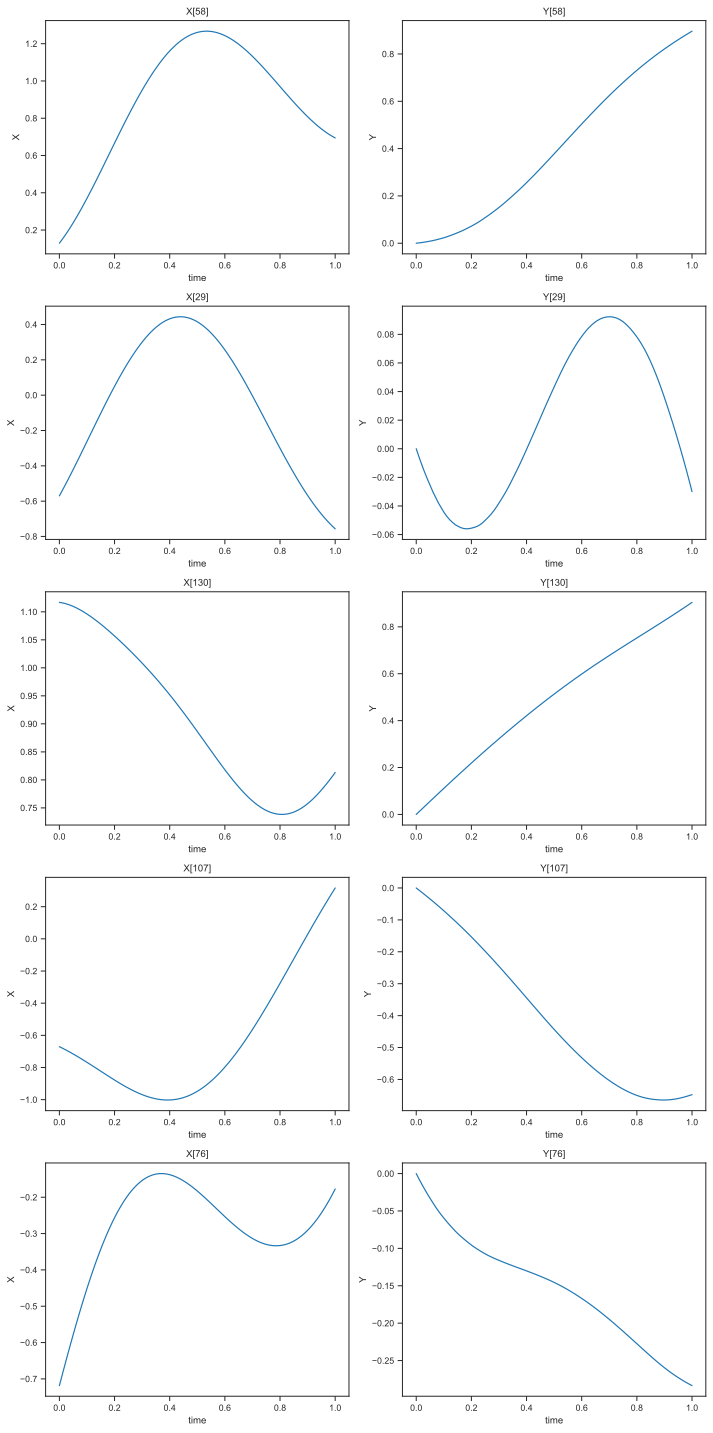

In [6]:
# Select a few random indices
random_indices = np.random.choice(branch_inputs_train.shape[0], 5, replace=False)

# Plot X and Y for the selected indices
fig,ax = plt.subplots(5,2,figsize=(10,20))

for idx, i in enumerate(random_indices):
    ax[idx, 0].plot(trunk_inputs_train[:, 0], branch_inputs_train[i])
    ax[idx, 0].set_title(f'X[{i}]')
    ax[idx, 0].set_xlabel('time')
    ax[idx, 0].set_ylabel('X')

    ax[idx, 1].plot(trunk_inputs_train[:, 0], outputs_train[i, :])
    ax[idx, 1].set_title(f'Y[{i}]')
    ax[idx, 1].set_xlabel('time')
    ax[idx, 1].set_ylabel('Y')

plt.tight_layout()
plt.show()

In [7]:
# Training Data in Jax Arrays
data_branch_train = jnp.array(branch_inputs_train)
data_trunk = jnp.array(trunk_inputs_train)
data_output_train = jnp.array(outputs_train)
data_branch_train.shape, data_trunk.shape, data_output_train.shape

((150, 100), (100, 1), (150, 100))

In [8]:
# Test Data in Jax Arrays
data_branch_test = jnp.array(branch_inputs_test)
data_branch_test.shape

(1000, 100)

# DeepONet Architecture

In [9]:
class DeepONet1d(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self,
        in_size_branch,
        width_size,
        depth,
        interact_size,
        activation,
        *,
        key,
    ):
        """
        For simplicity, branch and trunk MLP are configured similarly
        """
        b_key, t_key = jr.split(key)
        self.branch_net = eqx.nn.MLP(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=b_key,
        )
        self.trunk_net = eqx.nn.MLP(
            in_size=1,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            final_activation=activation,
            key=t_key,
        )
        self.bias = jnp.zeros((1,))

    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """
        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)
        inner_product = jnp.sum(branch_out * trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]

In [10]:
antiderivative_operator = DeepONet1d(
    in_size_branch=100,
    width_size=40,
    depth=1,
    interact_size=40,
    activation=jax.nn.relu,
    key=jr.PRNGKey(0),
)

print(antiderivative_operator)

DeepONet1d(
  branch_net=MLP(
    layers=(
      Linear(
        weight=f64[40,100],
        bias=f64[40],
        in_features=100,
        out_features=40,
        use_bias=True
      ),
      Linear(
        weight=f64[40,40],
        bias=f64[40],
        in_features=40,
        out_features=40,
        use_bias=True
      )
    ),
    activation=<wrapped function relu>,
    final_activation=<function <lambda>>,
    use_bias=True,
    use_final_bias=True,
    in_size=100,
    out_size=40,
    width_size=40,
    depth=1
  ),
  trunk_net=MLP(
    layers=(
      Linear(
        weight=f64[40,1],
        bias=f64[40],
        in_features=1,
        out_features=40,
        use_bias=True
      ),
      Linear(
        weight=f64[40,40],
        bias=f64[40],
        in_features=40,
        out_features=40,
        use_bias=True
      )
    ),
    activation=<wrapped function relu>,
    final_activation=<wrapped function relu>,
    use_bias=True,
    use_final_bias=True,
    in_size=1,
  

# Loss Function

In [11]:
def loss_fn(model, x_branch, x_trunk, y):
    # Full batch training

    # Vectorize over both the batches/samples and the query points
    predictions = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0),
        ),
        in_axes=(0, None)
    )(x_branch, x_trunk)

    mse = jnp.mean(jnp.square(predictions - y))
    return mse

# Training

## Optimizer

In [12]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(antiderivative_operator, eqx.is_array))

## Supervisor

In [13]:
@eqx.filter_jit
def update_fn(model, loss_fn, state, x_branch, x_trunk, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x_branch, x_trunk, y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

## Training Loop

In [15]:
loss_history = []
epochs = 10000
# Initialize the tqdm progress bar
progress_bar = tqdm.tqdm(range(epochs), desc="Training Progress")
for _ in progress_bar:
    antiderivative_operator, opt_state, loss = update_fn(antiderivative_operator,
                                                         loss_fn, opt_state,
                                                         data_branch_train,
                                                         data_trunk,
                                                         data_output_train)
    loss_history.append(loss)
    progress_bar.set_description(f"Loss: {loss:.2e}")

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Loss: 5.53e-06: 100%|██████████| 10000/10000 [00:25<00:00, 393.47it/s]


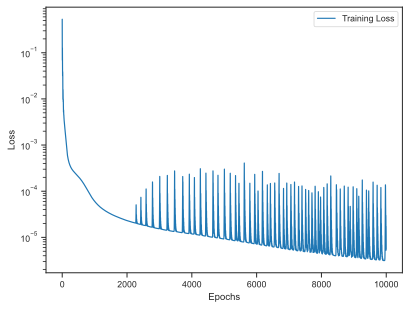

In [16]:
fig,ax = plt.subplots()
ax.semilogy(loss_history, label='Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

# Inference

In [17]:
pred_test = jax.vmap(
    jax.vmap(
        antiderivative_operator,
        in_axes=(None, 0)
    ),
    in_axes=(0, None,)
)(data_branch_test, data_trunk)

In [18]:
def normalized_l2_error(y_true, y_pred):
    diff_norm = jnp.linalg.norm(y_pred - y_true)
    ref_norm = jnp.linalg.norm(y_true)
    return (diff_norm / ref_norm)

In [19]:
# Select a few random indices
random_indices = np.random.choice(branch_inputs_test.shape[0], 5, replace=False)

def plot_predictions_vs_true(x_branch, x_trunk, y_true, y_pred, y_pred_std):
  # Plot X and Y for the selected indices
  fig,ax = plt.subplots(5,2,figsize=(10,20))

  for idx, i in enumerate(random_indices):
      ax[idx, 0].plot(x_trunk[:, 0], x_branch[i])
      ax[idx, 0].set_title(f'DeepONet Test Input: X[{i}]')
      ax[idx, 0].set_xlabel('time')
      ax[idx, 0].set_ylabel('$f(X_{test})$')

      # Calculate Error
      norm_l2_error = normalized_l2_error(y_true[i, :], y_pred[i, :])

      ax[idx, 1].plot(x_trunk[:, 0], y_true[i, :], label="True")
      ax[idx, 1].plot(x_trunk[:, 0], y_pred[i, :], '--', label="Predicted")
      if y_pred_std is not None:
        ax[idx,1].fill_between(x_trunk[:, 0],
                               y_pred[i, :] - 1.96 * y_pred_std[i],
                               y_pred[i, :] + 1.96 * y_pred_std[i],
                               alpha=0.5, label="CI")
      ax[idx, 1].set_title(f'DeepONet Test Predictions: Y[{i}]')
      ax[idx, 1].set_xlabel('time')
      ax[idx, 1].set_ylabel('$f(Y_{test})$')
      ax[idx, 1].legend()

      # Add RMSE text to the plot
      ax[idx, 1].text(0.05, 0.15, f'L2 Error: {norm_l2_error:.2f}',
              transform=ax[idx, 1].transAxes, verticalalignment='top',
              bbox=dict(facecolor='white', alpha=0.5))

  plt.tight_layout()
  plt.show()

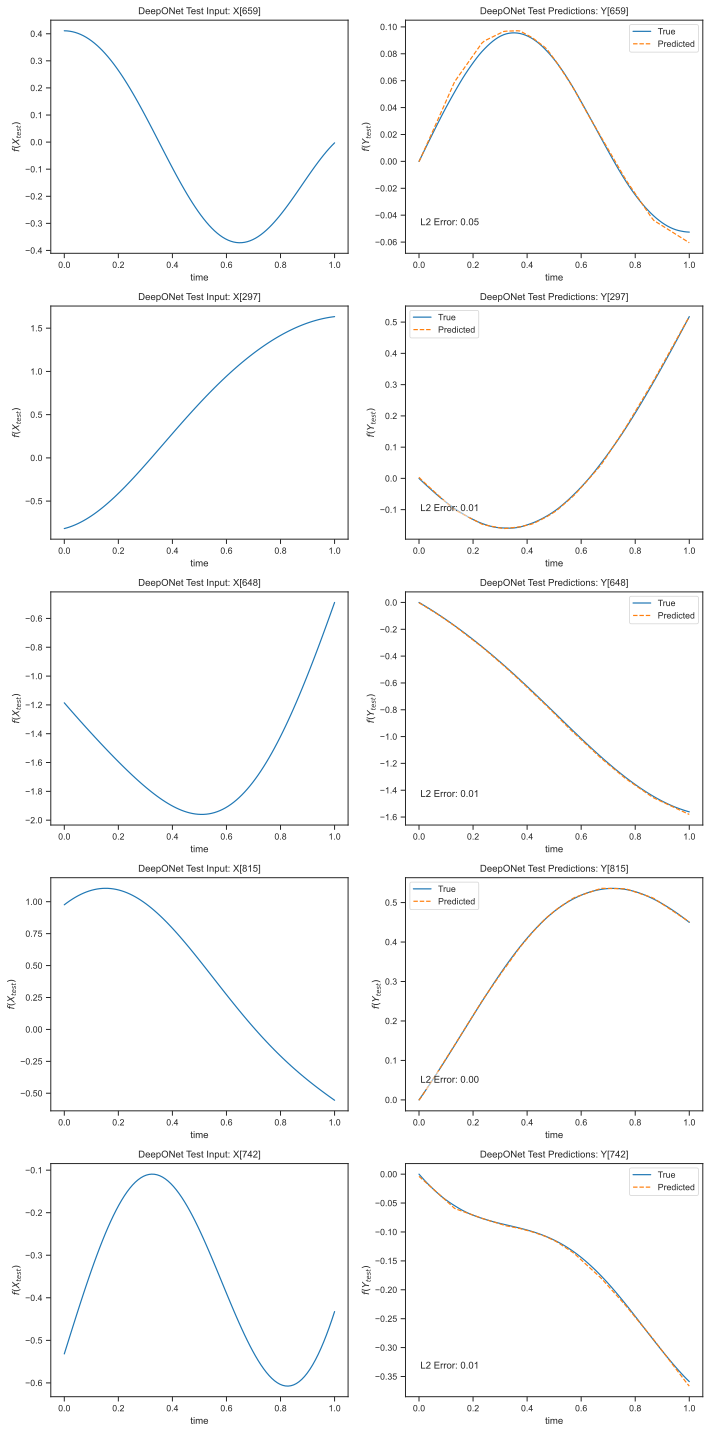

In [20]:
# Plot predictions
plot_predictions_vs_true(branch_inputs_test, trunk_inputs_test, outputs_test, pred_test, None)

In [21]:
# Print Error Statistics
norm_l2_error_mean = jnp.mean(jax.vmap(normalized_l2_error)(outputs_test, pred_test))
norm_l2_error_std = jnp.std(jax.vmap(normalized_l2_error)(outputs_test, pred_test))
print(f"Normalized L2 Error (Test): {norm_l2_error_mean:.2f} +- {norm_l2_error_std:.2f}")

Normalized L2 Error (Test): 0.01 +- 0.02
